# Classifying the Leaf Dataset

In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random as rd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [55]:
SIZE = 192
LABELS = 99
BREAKS = 50

---
## Visualizer Functions
These are some helper functions

In [56]:
def digits(data, labels, predictions=None):
    fig, ax = plt.subplots(3, 10, figsize = (20, 8))
    for i in xrange(3):
        for j in xrange(10):
            x = rd.randint(0, len(data))
            ax[i,j].matshow(data.reshape(-1, SIZE, SIZE)[x], cmap=cm.gray_r)
            ax[i,j].set_title("Label: {}".format(labels[x]))
            ax[i,j].axis('off')
    plt.show()

In [57]:
def plotter(history):
    at, av, lt, lv = zip(*history)
    fig = plt.figure(figsize=(15, 8)); ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

    ax1.plot(np.arange(0, len(at), 1), at,".-", color='#2A6EA6', label="Training: {0:.2f}%".format(at[-1]))
    ax1.plot(np.arange(0, len(av), 1), av,".-", color='#FFA933', label="Validation: {0:.2f}%".format(av[-1]))
    ax1.grid(True); ax1.legend(loc="lower right"); ax1.set_title("Accuracy per epoch")

    ax2.plot(np.arange(0, len(lt), 1), lt,".-", color='#2A6EA6', label="Training: {0:.2f}".format(lt[-1]))
    ax2.plot(np.arange(0, len(lv), 1), lv,".-", color='#FFA933', label="Validation: {0:.2f}".format(lv[-1]))
    ax2.grid(True); ax2.legend(loc="upper right"); ax2.set_title("Cost per epoch")
    plt.show()

---
## Data Import

In [58]:
data = pd.read_csv('/Users/desiredewaele/Google Drive/Datasets/LeafData/train.csv', index_col=0)
test = pd.read_csv('/Users/desiredewaele/Google Drive/Datasets/LeafData/test.csv', index_col=0)
labels = data.pop('species')

In [59]:
data.tail()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
id,,,,,,,,,,,,,,,,,,,,,
1575,0.060547,0.119140,0.007812,0.003906,0.000000,0.148440,0.017578,0.0,0.001953,0.042969,...,0.242190,0.000000,0.034180,0.000000,0.010742,0.000000,0.000000,0.000000,0.000000,0.018555
1578,0.001953,0.003906,0.021484,0.107420,0.001953,0.000000,0.000000,0.0,0.029297,0.003906,...,0.170900,0.000000,0.018555,0.000000,0.011719,0.000000,0.000000,0.000977,0.000000,0.021484
1581,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,0.003906,0.000000,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
1582,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,0.037109,0.001953,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930
1584,0.023438,0.019531,0.031250,0.015625,0.005859,0.019531,0.035156,0.0,0.003906,0.039062,...,0.000000,0.000000,0.002930,0.000000,0.012695,0.000000,0.000000,0.023438,0.025391,0.022461


In [60]:
labels.tail()

id
1575    Magnolia_Salicifolia
1578             Acer_Pictum
1581      Alnus_Maximowiczii
1582           Quercus_Rubra
1584          Quercus_Afares
Name: species, dtype: object

---
## Data Preproccessing
Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [61]:
print('Training set', data.shape, labels.shape)
print('Testing set', test.shape)

('Training set', (990, 192), (990,))
('Testing set', (594, 192))


In [62]:
data = data.values
test = test.values
labels = pd.get_dummies(labels).values

In [63]:
print('Training set', data.shape, labels.shape)
print('Testing set', test.shape)

('Training set', (990, 192), (990, 99))
('Testing set', (594, 192))


In [64]:
from sklearn.model_selection import train_test_split
trainX, validX, trainY, validY = train_test_split(data, labels, test_size=0.8, random_state=100)

In [65]:
print('Training set:', trainX.shape, trainY.shape)
print('Validation set:', validX.shape, validY.shape)
print('Testing set:', test.shape)

('Training set:', (198, 192), (198, 99))
('Validation set:', (792, 192), (792, 99))
('Testing set:', (594, 192))


---
## Neural Network 1

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [76]:
BATCH = 256
HIDDEN1 = 256
HIDDEN2 = 256
HIDDEN3 = 128
RATE = 0.2
STEPS = 18000

In [77]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tfDataX = tf.placeholder(tf.float32, shape=(None, SIZE))
    tfDataY = tf.placeholder(tf.float32, shape=(None, LABELS))

    # Variables.
    w1 = tf.Variable(tf.truncated_normal([SIZE, HIDDEN1], stddev=np.sqrt(2.0/SIZE)))
    w2 = tf.Variable(tf.truncated_normal([HIDDEN1, LABELS], stddev=np.sqrt(2.0/SIZE)))
    b1 = tf.Variable(tf.zeros([HIDDEN1]))
    b2 = tf.Variable(tf.zeros([LABELS]))

    # Model.
    def model(x):
        x = tf.nn.relu(tf.matmul(x, w1) + b1)
        return tf.matmul(x, w2) + b2
  
    # Training computation.
    logits = model(tfDataX)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY))
    rate = tf.train.exponential_decay(RATE, tf.Variable(0), 4000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(rate).minimize(loss)

    # Predictions and Accuracy.
    predictions = {"classes": tf.argmax(model(tfDataX), axis=1), "probabilities": tf.nn.softmax(model(tfDataX))}
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(predictions["classes"], tf.argmax(tfDataY, axis=1)))) * 100

In [78]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    history = []
    for step in range(STEPS):
        offset = (step * BATCH) % (trainY.shape[0] - BATCH)
        batchX, batchY = trainX[offset:(offset + BATCH), :], trainY[offset:(offset + BATCH), :]
        session.run(optimizer, {tfDataX: trainX, tfDataY: trainY})
        if(step % (STEPS // BREAKS) == 0):
            lt, at = session.run([loss, accuracy], {tfDataX: trainX, tfDataY: trainY})
            lv, av = session.run([loss, accuracy], {tfDataX: validX, tfDataY: validY})
            history.append((at, av, lt, lv))
            print ".",
    predictions = session.run(predictions, {tfDataX: test})
    #accuracy = session.run(accuracy, {tfDataX: testX, tfDataY: testY})
    #print('\nTest accuracy: %.2f%%' % accuracy)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


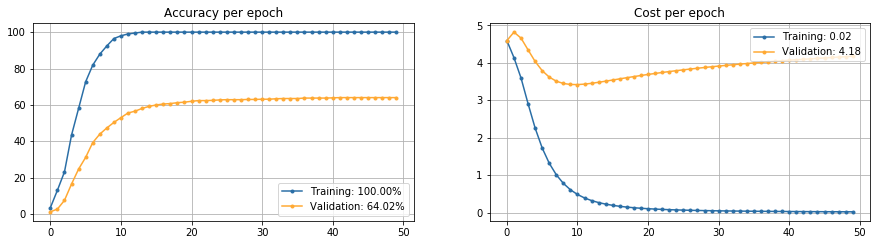

In [79]:
plotter(history)